In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Estimate the lake area at White Island from a single image
--

Multiple iterations are used, up to a maximum of $niter$. This is so that when there is some colour gradation in the lake, the opportunity to 'grow' the lake area estimate is available.

Sometimes the area estimate 'blows up' when it massively exceeds the lake area. It is not clear why this happens. This is handled by examining the ratio of the estimated area to the area from the previous iteration, and if it exceeds $maxinc$, the iterations stop, and the lake area estimate used is that of the previous iteration.

In some situations the lake area decreases from one iteration to the next. This seems odd and is probably not desirable. If this happens the iterations stop, and the lake area estimate used is that of the previous iteration.

Trying to use a small initial model area, for maximum flexibility during times of low lake level. This requires a larger $maxinc$ than I used with a larger initial model area.

The height of the lake, below the top of the image, is calculated from the final lake shore estimate (the contour) at a specified x value.

In [15]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
import numpy as np
import pandas as pd

%matplotlib inline

In [16]:
def innerrect(immask):
    '''find the inner rectangle of the largets area fully contained within an image mask'''
    #based on https://stackoverflow.com/questions/2478447/find-largest-rectangle-containing-only-zeros-in-an-n%C3%97n-binary-matrix
    #need not(mask) to get 0s in lake area mask
    a = cv2.bitwise_not(immask)
    
    nrows = a.shape[0]
    ncols = a.shape[1]

    skip = 255 #image mask so array values are 0 or 255
    area_max = (0, [])

    #zero arrays of same shape as image
    w = np.zeros(dtype=int, shape=a.shape)
    h = np.zeros(dtype=int, shape=a.shape)

    for r in range(nrows):
        for c in range(ncols):
            if a[r][c] == skip:
                continue
            if r == 0:
                h[r][c] = 1
            else:
                h[r][c] = h[r-1][c]+1
            if c == 0:
                w[r][c] = 1
            else:
                w[r][c] = w[r][c-1]+1
            minw = w[r][c]
            for dh in range(h[r][c]):
                minw = min(minw, w[r-dh][c])
                area = (dh+1)*minw
                if area > area_max[0]:
                    area_max = (area, [(r-dh, c-minw+1, r, c)])

    ymin = area_max[1][0][0]
    xmin = area_max[1][0][1]
    ymax = area_max[1][0][2]
    xmax = area_max[1][0][3]
    x_width = xmax - xmin
    y_width = ymax - ymin
    
    return(ymin, xmin, ymax, xmax, x_width, y_width)

In [17]:
def bproj(target, xmin, xmax, ymin, ymax):
    
    global result, model
    
    threshold = 0

    #crop from image
    model = target[ymin:ymax, xmin:xmax]

    #convert to hsv (hue, saturation, value)
    hsvm = cv2.cvtColor(model,cv2.COLOR_BGR2HSV)

    #calculate histogram of model
    histm = cv2.calcHist([hsvm],[0, 1], None, [180, 256], [0, 180, 0, 256])

    #normalize histogram values to 0-255, this makes it 0-255 x 0-255
    cv2.normalize(histm,histm,0,255,cv2.NORM_MINMAX)
    #apply backprojection
    dst = cv2.calcBackProject([hsvt],[0,1],histm,[0,180,0,256],1)

    #convolute with circular disc
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    dst = cv2.filter2D(dst,-1,disc,dst)

    #threshold and binary AND
    ret,thresh = cv2.threshold(dst,threshold,255,0)
    thresh = cv2.merge((thresh,thresh,thresh))
    res = cv2.bitwise_and(target,thresh) #get colour from image to show as result

    #apply morphological closing to the lake, to remove gaps inside https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    #kernel is 20x20, experimental
    kernel = np.ones((20,20),np.uint8)
    result = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    #how many pixels in the detected lake area?
    #grey version
    threshg = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

    #histogram of this
    hist = cv2.calcHist([threshg],[0],None,[256],[0,256])

    #number of white pixels, lake pixels are white so last element of array
    whtpx = float(hist[255])
                   
    return(whtpx)

In [18]:
def plotonimg(image):
    '''plot image contour (lake boundary) on original image'''
    
    #convert 
    threshg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #make a mask from the grey threshold image
    ret, mask = cv2.threshold(threshg, 10, 255, cv2.THRESH_BINARY) #actual threshold value not critical in this case?
    
    #set opacity based on the threshold image using the mask, so can plot lake area on image without covering the background
    b_channel, g_channel, r_channel = cv2.split(result)
    alpha_channel = mask
    thresh_BGRA = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
    
    #determine boundary of the mask as a contour, so can plot on image
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    #find the largest contour, as there might be more than one
    areas = [cv2.contourArea(c) for c in contours]
    max_index = np.argmax(areas)
    cnt=contours[max_index]
    
    #plot it
    RGBimg = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)
    fig,ax = plt.subplots(figsize=(10,5))
    ax.imshow(RGBimg)
    x = [a[0][0] for a in cnt]
    y = [a[0][1] for a in cnt]
    ax.plot(x,y, color='white')
    
    plt.savefig(base+'_lakeoutline.jpg')
    
    ht = estht(cnt, 400)
    
    return (ht)

In [19]:
def estht(contour, xpt):
    '''estimate lake height at a specific point from a lake boundary contour'''
    #xpt may not have a contour value, so use a range
    x1 = xpt - 10
    x2 = xpt + 10
    
    c = np.squeeze(contour) #drop any unused array dimensions

    #find rows having appropriate values
    rows = np.where((c>x1) & (c<x2) ) #returns arrays of row numbers
    rows = rows[0]
    
    #height is mean value for the rows
    ht = np.mean(c[rows][:,1])
    
    return(ht)

**parameters**

In [28]:
niter = 8 #number iterations
maxinc = 1.5

**target image, this is the image in which we want to find the lake**

In [21]:
# %gui qt

# from PyQt5.QtWidgets import QFileDialog

# def gui_fname(dir=None):
#     """Select a file via a dialog and return the file name."""
#     if dir is None: dir ='./'
#     fname = QFileDialog.getOpenFileName(None, "Select data file...", 
#                 dir, filter="All files (*);; SM Files (*.sm)")
#     return fname[0]

In [22]:
# gui_fname()

In [29]:
file = '20180301000003WIWR.jpg'
target = cv2.imread(file)

base = os.path.splitext(file)[0]

In [30]:
#convert target image to hsv (hue, saturation, value)
hsvt = cv2.cvtColor(target,cv2.COLOR_BGR2HSV)

**estimate lake area**

iter =  0  area =  48853.0
iter =  1  area =  76556.0
area ratio = 1.57
**backing up**
iter =  0  area =  48853.0


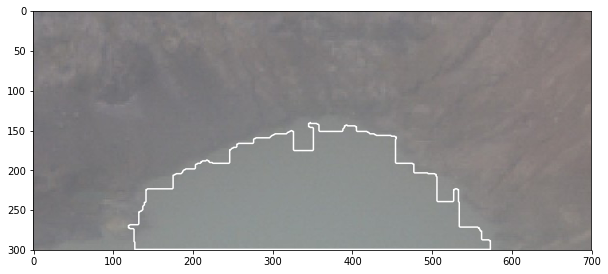

In [31]:
#crop area, used by initial estimate
xmin = 275
xmax = 350
ymin = 200
ymax = 275
# xmin = 300
# xmax = 325
# ymin = 250
# ymax = 275

lake = pd.DataFrame()

for iter in range(niter):
    if iter == 0:
        area = bproj(target, xmin, xmax, ymin, ymax) #back projection
        #previous results
        l_area = area
        l_result = result
        print ('iter = ', iter, ' area = ', area)
        d = {'area':area}
        df = pd.DataFrame(d, index=[iter])
        lake = lake.append(df)
    else:
        #iterations after initial one
        #make mask from previous estimate gray scale
        mask = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

        #largest inner rectangle from mask
        (ymin, xmin, ymax, xmax, x_width, y_width) = innerrect(mask)

        area = bproj(target, xmin, xmax, ymin, ymax) #back projection
        print ('iter = ', iter, ' area = ', area)
        
        print ('area ratio = {:4.2f}'.format(area/l_area))
        
        #if area increases to much a blowup, backup and break
        if (area > l_area*maxinc)or(area/l_area < 1):
            print ('**backing up**')
            area = l_area
            result = l_result
            iter -= 1
            print ('iter = ', iter, ' area = ', area)
            break
                  
        #previous results
        l_area = area
        l_result = result
                
        d = {'area':area}
        df = pd.DataFrame(d, index=[iter])
        lake = lake.append(df)
lake.index.name = 'iteration'
ht = plotonimg(result)

In [32]:
print ('lake height = {:}'.format(int(ht)))

lake height = 145


**display lake area vs iteration**

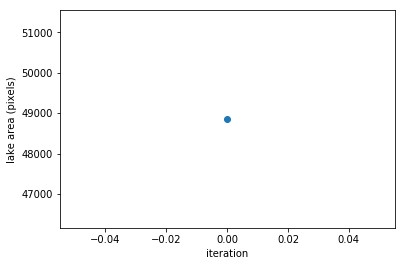

In [33]:
la = lake.plot(marker='o', legend=False)
la.set_ylabel('lake area (pixels)')

plt.savefig(base+'_lakearea.png')